## Toin coss model with Pyro

In [1]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(1.0)
    beta0 = torch.tensor(1.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

....................
based on the data and our prior belief, the fairness of the coin is 0.587 +- 0.093


Note that:
1. each observation (obs_i) is assigned a unique name (see model)
2. model and guide have the same signature
3. the name of pyro.sample (latent_fairness) is the same in model and guide

In [2]:
prior=dist.Beta(1,1)
posterior=dist.Beta(pyro.param("alpha_q").item(),pyro.param("beta_q").item())

(array([ 995.,  990.,  965., 1041.,  982., 1040., 1015.,  988.,  971.,
        1013.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([   0.,    0.,    8.,  219., 1591., 3671., 3353., 1103.,   55.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

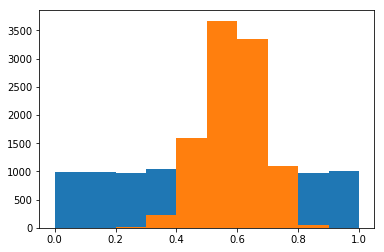

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
sample = posterior.sample(torch.Size([10000]))
sample2 = prior.sample(torch.Size([10000]))
display(plt.hist(sample2,range=(0,1),bins=10))
display(plt.hist(sample,range=(0,1),bins=10))

## Conditional independence and parallelism

In [4]:
# Serial version, do not leverage conditional independence
def model1(data):
    f = pyro.sample("latent_fairness", dist.Beta(torch.tensor(1.0),torch.tensor(1.0)))
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

# Serial version with conditional independence
def model2(data):    
    f = pyro.sample("latent_fairness", dist.Beta(torch.tensor(1.0),torch.tensor(1.0)))
    for i in pyro.irange("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

# Parallel version conditional independence
def model3(data):
    f = pyro.sample("latent_fairness", dist.Beta(torch.tensor(1.0),torch.tensor(1.0)))
    with pyro.iarange('observe_data'):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)
        
# Generate the data
data_list_of_tensor = []
for _ in range(9):
    data_list_of_tensor.append(torch.tensor(1.0))
for _ in range(1):
    data_list_of_tensor.append(torch.tensor(0.0))
    
data_tensor = torch.zeros(10)
data_tensor[0:9] = torch.ones(1)

print(type(data_tensor))
print(type(data_list_of_tensor))

<class 'torch.Tensor'>
<class 'list'>


In [5]:
def compute_beta_prop(alpha,beta):
    mean = alpha / (alpha + beta)
    fact = beta / (alpha * (1.0 + alpha + beta))
    std  = mean * math.sqrt(fact)
    print("result = %.3f +- %.3f" % (mean,std))

    
n_step=2000

svi1 = SVI(model1, guide, optimizer, loss=Trace_ELBO())
for step in range(n_steps):
    svi1.step(data_list_of_tensor)
    if step % 100 == 0:
        print('.', end='')
alpha_1 = pyro.param("alpha_q").item()
beta_1  = pyro.param("beta_q").item()
print('Estimated alpha,beta=',alpha_1,beta_1)


svi2 = SVI(model2, guide, optimizer, loss=Trace_ELBO())
for step in range(n_steps):
    svi2.step(data_list_of_tensor)
    if step % 100 == 0:
        print('.', end='')
alpha_2 = pyro.param("alpha_q").item()
beta_2  = pyro.param("beta_q").item()
print('Estimated alpha,beta=',alpha_2,beta_2)

svi3 = SVI(model3, guide, optimizer, loss=Trace_ELBO())
for step in range(n_steps):
    svi3.step(data_tensor)
    if step % 100 == 0:
        print('.', end='')
alpha_3 = pyro.param("alpha_q").item()
beta_3  = pyro.param("beta_q").item()
print('Estimated alpha,beta=',alpha_3,beta_3)

compute_beta_prop(alpha_1,beta_1)
compute_beta_prop(alpha_2,beta_2)
compute_beta_prop(alpha_3,beta_3)

....................Estimated alpha,beta= 26.01880645751953 5.4173455238342285
....................Estimated alpha,beta= 23.322593688964844 4.380270957946777
....................Estimated alpha,beta= 20.175762176513672 3.729942798614502
result = 0.828 +- 0.066
result = 0.842 +- 0.068
result = 0.844 +- 0.073
